<class 'pandas.core.frame.DataFrame'>
RangeIndex: 696 entries, 0 to 695
Columns: 874 entries, anr to nach_cockpit_e
dtypes: float64(450), int64(40), object(384)
memory usage: 4.6+ MB


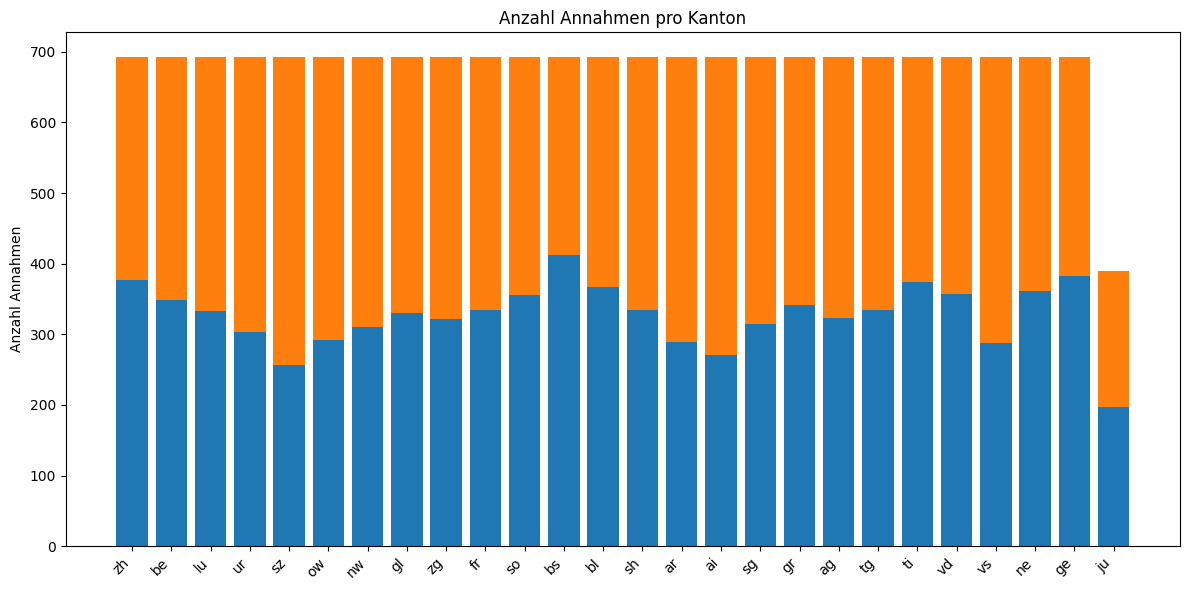

In [75]:
# Import der nötigen Pakete
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Daten einlesen
df = pd.read_csv('Data/dataset.csv', delimiter=";")

# Ausgeben der ersten Zeile
df.head()

# Struktur der Daten
df.info()
df.describe()

# Filtern und Bereinigen der Daten
# Wähle nur Spalten aus, die '-annahme' im Namen haben
df_filtered = df[[col for col in df.columns if '-annahme' in col]]

# Ersetze problematische Zeichen und konvertiere zu numerischen Werten:
# '.' und 'z' werden zu NaN (fehlende Werte)
# '1' wird zu 1 (Annahme)
# '0' wird zu 0 (Ablehnung)
df_filtered = df_filtered.replace({'.': np.nan, 'z': np.nan, '1': 1, '0': 0})
# Konvertiere alle Werte zu numerischem Format
# errors='coerce' wandelt nicht-konvertierbare Werte in NaN um
df_filtered = df_filtered.apply(pd.to_numeric, errors='coerce')

# Erstelle Visualisierung
# Figurengröße 12x6 Zoll für gute Lesbarkeit
fig, ax = plt.subplots(figsize=(12, 6))

# Berechne die Summe der Annahmen pro Kanton
acceptance_counts = (df_filtered == 1).sum()
rejected_counts = (df_filtered == 0).sum()

# Erstelle Balkendiagramm
ax.bar(acceptance_counts.index.str.replace("-annahme", ""), acceptance_counts.values)
ax.bar(rejected_counts.index.str.replace("-annahme", ""), rejected_counts.values, bottom=acceptance_counts.values)

# Formatiere die Darstellung
plt.xticks(rotation=45, ha='right')  # Drehe Beschriftungen für bessere Lesbarkeit
plt.title('Anzahl Annahmen pro Kanton')
plt.ylabel('Anzahl Annahmen')
plt.tight_layout()  # Optimiere Layout automatisch

# Plotte das Diagramm
plt.show()